# 09_Simple-MLP-unsupervised-prune


In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
from src.simple_pruning_growth_model import DrLIMPruneGrowNetwork, ContrastiveLoss, constrative_test_loop
from src.training_testing_loop import full_train, save_model_attr, format_training_outputs
from src.load_MNIST import get_mnist_pairs_loader
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from datetime import date
import pickle

In [3]:
train_pair_dataloader, val_pair_dataloader = get_mnist_pairs_loader(
    batch_size=32, train=True, subset_fraction=0.05, validation_ratio=6, seed=42, 
    selected_labels=[4, 9]
)
test_pair_dataloader = get_mnist_pairs_loader(batch_size=32, train=False, subset_fraction=0.05,  selected_labels=[4, 9])

device: cuda
num_workers: 0
device: cuda
num_workers: 0


In [4]:
train_pair_dataloader.dataset.dataset.pair_labels.shape

(1178,)

Pruning, linear prediction activation

In [18]:
training_fn = f"./outputs/09/DrLIM_training.{date.today()}"
training_fn

'./outputs/09/DrLIM_training.2024-12-11'

In [70]:
DrLIM_model = DrLIMPruneGrowNetwork(
    gamma=0.1, init_density=0.5, num_training_iter=500,
    low_mapping_dim=2, prediction_act=lambda x: x, use_grow_prune_prob=True
)
DrLIM_model.to(device='cpu:0')

contrastive_loss_fn = ContrastiveLoss(m=5) # if I am using tanh, range is between -1 and 1.
val_contrastive_loss_fn = ContrastiveLoss(m=5, reduction='sum')

train_losses_epoch, val_losses_epoch, test_df, model_state_dicts = full_train(
    DrLIM_model, train_pair_dataloader, val_pair_dataloader, test_pair_dataloader,
    model_training_output_dir=training_fn,
    override=True,
    learning_rate = 1e-3, 
    loss_fn=contrastive_loss_fn,
    val_loss_fn=val_contrastive_loss_fn,
    plot=False, verbose=False,
    test_loop_func=constrative_test_loop,
    margin=contrastive_loss_fn.m,
    args_expand=True,
)

./outputs/09/DrLIM_training.2024-12-11 already exists and override is True. Interrupt before training ends to prevent overwriting.


Epochs:  33%|███▎      | 163/500 [04:38<09:34,  1.71s/it]


KeyboardInterrupt: 

In [58]:
stack_training_losses_df = pd.read_csv(f"{training_fn}/stack_training_losses.tsv", sep='\t')
stack_val_losses_df = pd.read_csv(f"{training_fn}/stack_val_losses.tsv", sep='\t')
test_df = pd.read_csv(f"{training_fn}/test_err_loss.tsv", sep='\t')

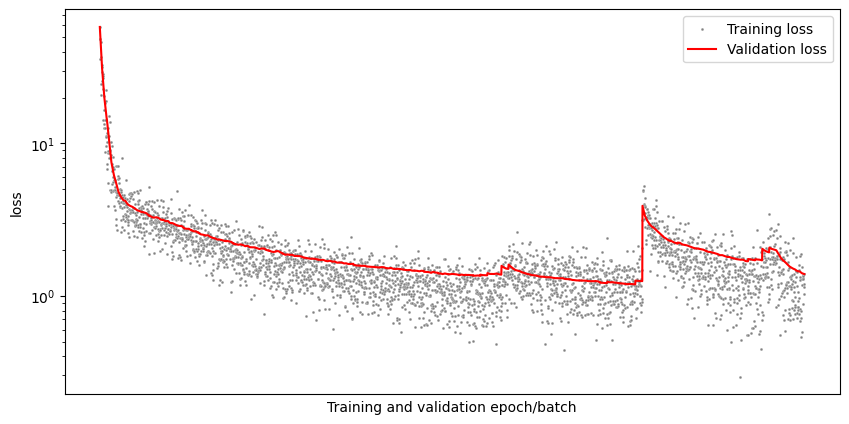

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(stack_training_losses_df, x='index', y='loss', label='Training loss', alpha=1.0, c='gray', s=4, ax=ax)
sns.lineplot(stack_val_losses_df, x='index', y='loss',  label='Validation loss', c='red', ax=ax)
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.yscale('log')
plt.show()

In [60]:
with open(f"{training_fn}/model_attr.pkl", "rb") as fh:
    model_attr = pickle.load(fh)

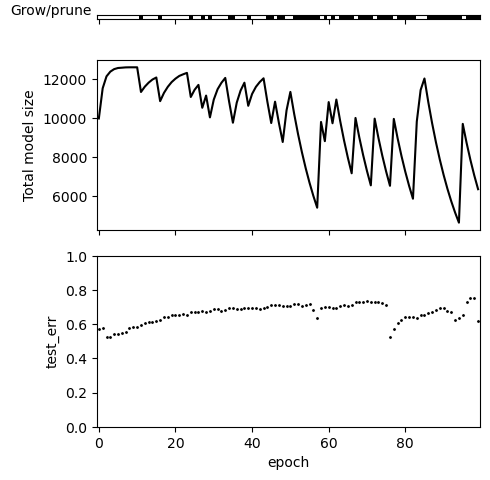

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(5, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(np.array(model_attr['grow_prune_history']).reshape(1, -1)), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("Grow/prune", rotation=0, ha='right')

axes[1].plot(model_attr['synapse_count_history'], c='k') 
axes[1].set_ylabel("Total model size")

sns.scatterplot(test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()


In [62]:
test_df.sort_values(by='test_err', ascending=True)

,epoch,test_err,test_loss
76,76,0.525253,130.828169
2,2,0.525253,165.412114
3,3,0.525253,150.570250
4,4,0.540404,146.571940
5,5,0.540404,142.826826
...,...,...,...
67,67,0.727273,74.546840
71,71,0.727273,73.606901
70,70,0.737374,73.382869
97,97,0.752525,67.268816


In [63]:
with open(f"{training_fn}/model_state_dicts.pkl", "rb") as fh:
    model_state_dicts = pickle.load(fh)

In [64]:
model_state_dicts.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [67]:
trained_DrLIM_model = DrLIMPruneGrowNetwork(
    gamma=0.1, init_density=0.5, num_training_iter=100,
    low_mapping_dim=2, prediction_act=lambda x: x, use_grow_prune_prob=True
)
trained_DrLIM_model.load_state_dict(model_state_dicts[76])

<All keys matched successfully>

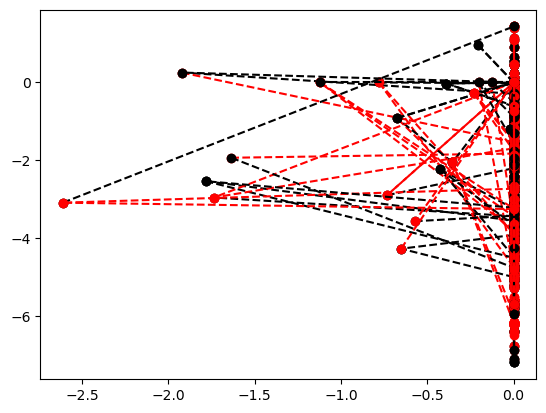

In [69]:
trained_DrLIM_model.eval()
colors = {1: 'ro--', 0: 'ko--'}
with torch.no_grad():
    for X, y in train_pair_dataloader:
        pred = trained_DrLIM_model(X)
        for i in range(len(pred[0])):
            plt.plot([pred[0][i, 0], pred[1][i, 0]], [pred[0][i, 1], pred[1][i, 1]], colors[y[i].item()])
    plt.show()

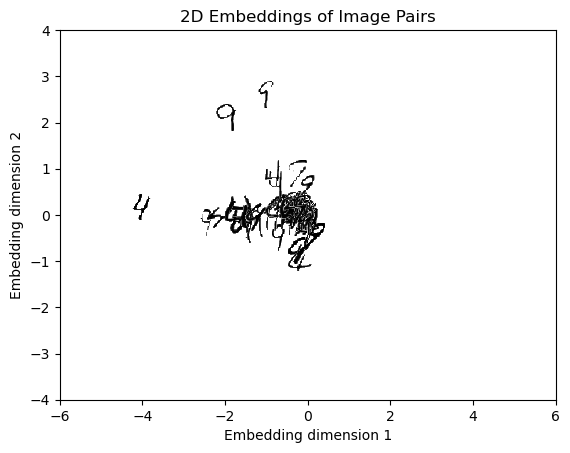

In [56]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

DrLIM_model.eval()
colors = {1: 'red', 0: 'black'}  # Solid colors for points
line_styles = {1: 'r--', 0: 'k--'}  # Dashed lines for connections
fig, ax = plt.subplots()

ax.set_xlabel('Embedding dimension 1')
ax.set_ylabel('Embedding dimension 2')
ax.set_title('2D Embeddings of Image Pairs')
ax.set_ylim(-4, 4)
ax.set_xlim(-6, 6)

def plot_img_embedding(img, x, y):
    img[img < -0.1] = np.nan
    im = OffsetImage(img, cmap='gray_r', zoom=1.0)
    return AnnotationBbox(im, (x, y), xycoords='data', frameon=False)

with torch.no_grad():
    artists = []
    for X, y in train_pair_dataloader:
        pred = trained_DrLIM_model(X)

        for i in range(len(pred[0])):
            # Plot points for both images in the pair
            # plt.scatter(pred[0][i, 0], pred[0][i, 1], c=colors[y[i].item()], alpha=0.6)
            # plt.scatter(pred[1][i, 0], pred[1][i, 1], c=colors[y[i].item()], alpha=0.6)
            
            ab = plot_img_embedding(X[0][i].permute(1, 2, 0).numpy(), pred[0][i, 0].item(), pred[0][i, 1].item())
            ax.add_artist(ab)

            ab = plot_img_embedding(X[1][i].permute(1, 2, 0).numpy(), pred[1][i, 0].item(), pred[1][i, 1].item())
            ax.add_artist(ab)
            
        break
                
    plt.show()
